# To do

In [21]:
%pip install pycofbuilder simplejson gemmi

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import time
import os
import pycofbuilder as pcb

def log_step(step_name):
    """Helper to print a timestamped log."""
    print(f"[{time.strftime('%H:%M:%S')}] {step_name}")

def main():
    print("--- STARTING COF ASSEMBLY PROCESS ---\n")
    
    # ---------------------------------------------------------
    # STEP 1: DEFINE BUILDING BLOCKS (Hardcoded for this demo)
    # ---------------------------------------------------------
    start_time = time.time()
    log_step("STEP 1: Selecting Building Blocks...")

    # Node: Triangular symmetry (T3), Benzene core, Aldehyde connector (-CHO)
    node_symmetry = "T3"
    node_core     = "BENZ"
    node_conn     = "CHO"
    node_func     = "OH"  # Functional group on the node (Hydroxy)
    
    # Linker: Linear symmetry (L2), Benzene core, Amine connector (-NH2)
    linker_symmetry = "L2"
    linker_core     = "BENZ"
    linker_conn     = "NH2"
    linker_func     = "H"   # No functional group (Hydrogen)

    # Topology & Stacking
    topology = "HCB"      # Honeycomb
    stacking = "AA"       # AA Stacking (layers aligned)
    net_type = "A"        # Standard net

    # Construct the Machine-Readable String (The "AI Handoff")
    # Format: {NodeSym}_{NodeCore}_{NodeConn}_{NodeFunc}-{LinkerSym}_{LinkerCore}_{LinkerConn}_{LinkerFunc}-{Top}_{Net}-{Stack}
    cof_name = f"{node_symmetry}_{node_core}_{node_conn}_{node_func}-{linker_symmetry}_{linker_core}_{linker_conn}_{linker_func}-{topology}_{net_type}-{stacking}"
    print(f"   -> Node Selected:   {node_symmetry}_{node_core} (Functionalized with -{node_func})")
    print(f"   -> Linker Selected: {linker_symmetry}_{linker_core}")
    print(f"   -> Target Topology: {topology}")
    print(f"   -> Generated ID:    {cof_name}")
    
    step_1_time = time.time()
    print(f"   (Selection took: {step_1_time - start_time:.4f}s)\n")

    # ---------------------------------------------------------
    # STEP 2: INITIALIZE FRAMEWORK OBJECT
    # ---------------------------------------------------------
    log_step("STEP 2: Initializing Framework Object...")
    
    # This step parses the string and loads the atomic data for the blocks
    cof = pcb.Framework(cof_name)
    
    step_2_time = time.time()
    print(f"   -> Framework object created in memory.")
    print(f"   (Initialization took: {step_2_time - step_1_time:.4f}s)\n")

    # ---------------------------------------------------------
    # STEP 3: GEOMETRIC ASSEMBLY & GENERATION
    # ---------------------------------------------------------
    log_step("STEP 3: Assembling Atoms & Generating Unit Cell...")
    
    # Note: pyCOFBuilder usually builds lazily or upon save. 
    # We trigger a save to force the generation of the .cif file.
    output_dir = "generated_cofs"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # We generate a 2x2x2 supercell to visualize the pores better
    supercell_size = [1, 1, 2] 
    
    print(f"   -> target directory: ./{output_dir}")
    print(f"   -> supercell size: {supercell_size}")

    # The heavy lifting happens here
    save_start = time.time()
    cof.save(fmt='cif', supercell=supercell_size, save_dir=output_dir)
    save_end = time.time()

    print(f"   -> Structure assembled and saved as {cof_name}.cif")
    print(f"   (Assembly & Save took: {save_end - save_start:.4f}s)\n")

    # ---------------------------------------------------------
    # STEP 4: VERIFICATION & SUMMARY
    # ---------------------------------------------------------
    log_step("STEP 4: Final Summary")
    
    total_time = time.time() - start_time
    
    # Assuming the library populates these after build (depending on version)
    # If not available directly, we skip printing specific atom counts to avoid errors.
    print(f"   -> Total Process Time: {total_time:.4f}s")
    print(f"   -> File Location: {os.path.abspath(output_dir)}/{cof_name}.cif")
    print("\n--- PROCESS COMPLETE ---")

if __name__ == "__main__":
    main()

--- STARTING COF ASSEMBLY PROCESS ---

[22:52:08] STEP 1: Selecting Building Blocks...
   -> Node Selected:   T3_BENZ (Functionalized with -OH)
   -> Linker Selected: L2_BENZ
   -> Target Topology: HCB
   -> Generated ID:    sql_PTCA_STAR1_COF
   (Selection took: 0.0000s)

[22:52:08] STEP 2: Initializing Framework Object...


AssertionError: FrameworkName must be in the format: BB1-BB2-Net-Stacking

In [23]:
%pip install stk

Note: you may need to restart the kernel to use updated packages.


In [24]:
import stk

# 1. Define Building Blocks with explicit functional groups
# This gives you control over rotation and bond angles
amine_block = stk.BuildingBlock(
    smiles='Nc1ccc(N)cc1',  # Benzene diamine
    functional_groups=[stk.PrimaryAminoFactory()]
)

aldehyde_block = stk.BuildingBlock(
    smiles='O=Cc1cc(C=O)cc(C=O)c1',  # Benzene trialdehyde
    functional_groups=[stk.AldehydeFactory()]
)

# 2. Define the Topology Graph
# "Honeycomb" lattice, but stk calculates the bond vectors dynamically
cof = stk.ConstructedMolecule(
    topology_graph=stk.cof.Honeycomb(
        building_blocks=(amine_block, aldehyde_block),
        lattice_size=(2, 2, 1)
    )
)

print(cof)
# 3. Write to file
cof.write('stk_cof.pdb')

<ConstructedMolecule at 14195392784>


<ConstructedMolecule at 14195392784>

In [25]:
# Core imports for this notebook

from aiida.manage.configuration import load_profile
from aiida import orm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from helper_functions import *

# This loads your default AiiDA profile (created via `verdi presto`).
# If you have multiple profiles, you can pass a name: load_profile('presto')
load_profile("new_cof")

print("✅ AiiDA profile loaded")


✅ AiiDA profile loaded


In [26]:
from aiida import orm

# All per-COF groups, e.g. 'discover_curated_cofs/05001N2'
cof_groups = list(orm.Group.objects.find(
    filters={'label': {'like': 'discover_curated_cofs/%'}}
))
print("Number of COF groups:", len(cof_groups))
for g in cof_groups[:5]:
    print("-", g.label)


Number of COF groups: 871
- discover_curated_cofs/2245fN2
- discover_curated_cofs/22000N2
- discover_curated_cofs/20490N2
- discover_curated_cofs/21451N2
- discover_curated_cofs/20491N2


/var/folders/yf/8kfy4_g531xbzb24dx_qk7yc0000gp/T/ipykernel_71942/2780561516.py:4: AiidaDeprecationWarning: `objects` property is deprecated, use `collection` instead. (this will be removed in v3)
  cof_groups = list(orm.Group.objects.find(


In [27]:
# Let's pick the first COF group and see what nodes it contains.

id = "20491N2"
example_group = get_group_by_ID(id,cof_groups)
print("Using COF group:", example_group.label)
print("Number of nodes in this group:", example_group.count())

# List nodes with their tag4 extras (which tell us what they represent)
for node in example_group.nodes:
    tag = node.base.extras.get('tag4', 'NO_TAG')
    print(f"PK {node.pk:7d} | {node.node_type:35s} | tag4 = {tag}")


Using COF group: discover_curated_cofs/20491N2
Number of nodes in this group: 21
PK    6844 | data.core.dict.Dict.                | tag4 = isot_n2
PK   32853 | data.core.dict.Dict.                | tag4 = appl_ch4storage
PK   37163 | data.core.dict.Dict.                | tag4 = appl_h2storage
PK   42717 | data.core.dict.Dict.                | tag4 = isotmt_h2
PK   62666 | data.core.dict.Dict.                | tag4 = opt_zeopp
PK  111085 | data.core.dict.Dict.                | tag4 = appl_peng
PK  115478 | data.core.dict.Dict.                | tag4 = kh_h2s
PK  190866 | data.core.dict.Dict.                | tag4 = appl_pecoal
PK  212951 | data.core.dict.Dict.                | tag4 = appl_h2sh2osel
PK  253323 | data.core.dict.Dict.                | tag4 = orig_zeopp
PK  265527 | data.core.dict.Dict.                | tag4 = kh_h2o
PK  288849 | data.core.dict.Dict.                | tag4 = appl_xekrsel
PK  298969 | data.core.dict.Dict.                | tag4 = isot_ch4
PK  341767 | data.core

In [28]:
def inspect_group_by_node_tag(group,tag):
    for node in group.nodes:
        if node.base.extras.get("tag4") == tag:
            inspect_node(node)
            return

In [29]:
example_group.label

'discover_curated_cofs/20491N2'

In [30]:
inspect_group_by_node_tag(example_group,"opt_zeopp")

PK:        62666
Class:     <class 'aiida.orm.nodes.data.dict.Dict'>
Node type: data.core.dict.Dict.

Extras:
  tag4: opt_zeopp

Attributes:
  psd: {'bins': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14.0, 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15.0, 15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 

1- Efficient/quick simulatioms for COF stability under conditions ( for ground truth )?
2- using simulations to train a reasoning LLM using RLVR to map conditions to properties
3- penneylene

## Pipeline

1- Reasoning LLM:
    * Site Conditions (temp. Humidity. Acidity. Pressure, Function) MCP? to implement stk tool calling ---> Reasoning LLM (gemini-pro-3) ---> Properties ( Pore size, etc... ) ---> [Post Training] ( Simulation ) RLVR


2- GNNs:

    * Given Properties ( Pore size, etc... ) --> GNNs --> Building Blocks ( monomers, linkers, topology, etc. )? (features)? --> COF structure


    

In [31]:
tags = sorted({node.base.extras.get('tag4', 'NO_TAG') for node in example_group.nodes})
print("Distinct tag4 values in this group:")
for t in tags:
    print("-", t)


Distinct tag4 values in this group:
- appl_ch4storage
- appl_h2sh2osel
- appl_h2storage
- appl_o2storage
- appl_pecoal
- appl_peng
- appl_xekrsel
- dftopt
- isot_ch4
- isot_co2
- isot_n2
- isot_o2
- isotmt_h2
- kh_h2o
- kh_h2s
- kh_kr
- kh_xe
- opt_cif_ddec
- opt_zeopp
- orig_cif
- orig_zeopp


In [32]:
import os
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

from aiida import orm
from aiida.manage.configuration import load_profile


def generate_cof_report(cof_label, output_dir="cof_reports", profile_name=None):
    """
    Generate a Markdown report for a given COF, with plots and scalar summaries.

    Parameters
    ----------
    cof_label : str
        Either the full group label, e.g. "discover_curated_cofs/05001N2",
        or just the COF ID, e.g. "05001N2".
    output_dir : str
        Base directory where a subfolder for this COF will be created.
    profile_name : str or None
        If not None, will call load_profile(profile_name) first.
        If None, assumes the profile is already loaded.
    """
    # ------------------------------
    # 0. Load profile if requested
    # ------------------------------
    if profile_name is not None:
        try:
            load_profile(profile_name)
            print(f"✅ Loaded AiiDA profile: {profile_name}")
        except Exception as exc:
            print(f"⚠️ Failed to load profile '{profile_name}': {exc}")
            print("   Continuing with current profile...")
    
    # ------------------------------
    # 1. Resolve group label & COF ID
    # ------------------------------
    if cof_label.startswith("discover_curated_cofs/"):
        group_label = cof_label
        cof_id = cof_label.split("/", 1)[1]
    else:
        cof_id = cof_label
        group_label = f"discover_curated_cofs/{cof_id}"
    
    print(f"🔍 Looking for group: {group_label}")
    try:
        group = orm.Group.objects.get(label=group_label)
    except Exception as exc:
        print(f"❌ Could not find group '{group_label}': {exc}")
        return
    
    print(f"✅ Found COF group with {group.count()} nodes")
    
    # ------------------------------
    # 2. Prepare filesystem
    # ------------------------------
    cof_dir = os.path.join(output_dir, cof_id)
    os.makedirs(cof_dir, exist_ok=True)
    
    def save_fig(name):
        """Helper: save current matplotlib figure into this COF's folder."""
        path = os.path.join(cof_dir, name)
        plt.tight_layout()
        plt.savefig(path, dpi=200, bbox_inches="tight")
        plt.close()
        return name  # return just the filename for markdown
    
    # ------------------------------
    # 3. Collect nodes by tag4
    # ------------------------------
    structures = {}
    porosity_nodes = {}
    isotherm_nodes = {}
    henry_nodes = {}
    appl_nodes = {}
    other_nodes = []
    
    for node in group.nodes:
        tag4 = node.base.extras.get("tag4")
        if not tag4:
            other_nodes.append(node)
            continue
        
        if tag4 in {"orig_cif", "dftopt", "opt_cif_ddec"}:
            structures[tag4] = node
        elif tag4 in {"orig_zeopp", "opt_zeopp"}:
            porosity_nodes[tag4] = node
        elif tag4.startswith("isot_") or tag4.startswith("isotmt_"):
            isotherm_nodes[tag4] = node
        elif tag4.startswith("kh_"):
            henry_nodes[tag4] = node
        elif tag4.startswith("appl_"):
            appl_nodes[tag4] = node
        else:
            other_nodes.append(node)
    
    # Prefer optimized porosity if available, else original
    zeopp = porosity_nodes.get("opt_zeopp") or porosity_nodes.get("orig_zeopp")
    
    # ------------------------------
    # 4. Build Markdown report
    # ------------------------------
    lines = []
    
    def add(md):
        """Append a line to the report."""
        lines.append(md)
    
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Header
    add(f"# COF Report: `{cof_id}`")
    add("")
    add(f"*Generated: {timestamp}*")
    add("")
    add(f"**AiiDA group label:** `{group_label}`")
    add("")
    
    # Node summary
    add("## Node overview")
    add("")
    add("| Category | Count | Tags |")
    add("|----------|-------|------|")
    add(f"| Structures | {len(structures)} | {', '.join(sorted(structures.keys())) or '—'} |")
    add(f"| Porosity (Zeo++) | {len(porosity_nodes)} | {', '.join(sorted(porosity_nodes.keys())) or '—'} |")
    add(f"| Isotherms | {len(isotherm_nodes)} | {', '.join(sorted(isotherm_nodes.keys())) or '—'} |")
    add(f"| Henry coefficients | {len(henry_nodes)} | {', '.join(sorted(henry_nodes.keys())) or '—'} |")
    add(f"| Applications | {len(appl_nodes)} | {', '.join(sorted(appl_nodes.keys())) or '—'} |")
    add(f"| Other nodes | {len(other_nodes)} | — |")
    add("")
    
    # ------------------------------
    # 5. Porosity / Zeo++ section
    # ------------------------------
    add("## Structural & Porosity (Zeo++)")
    add("")
    
    if zeopp is None:
        add("_No Zeo++ porosity node (`orig_zeopp` or `opt_zeopp`) found._")
        add("")
    else:
        attrs = zeopp.base.attributes.all
        
        density = attrs.get("Density")
        density_unit = attrs.get("Density_unit", "g/cm^3")
        poav = attrs.get("POAV_cm^3/g")
        poav_vf = attrs.get("POAV_Volume_fraction")
        av = attrs.get("AV_cm^3/g")
        av_vf = attrs.get("AV_Volume_fraction")
        asa = attrs.get("ASA_m^2/g")
        asa_vol = attrs.get("ASA_m^2/cm^3")
        n_channels = attrs.get("Number_of_channels")
        n_pockets = attrs.get("Number_of_pockets")
        lfs = attrs.get("Largest_free_sphere")
        lis = attrs.get("Largest_included_sphere")
        lifs = attrs.get("Largest_included_free_sphere")
        
        add(f"Using node: `tag4 = {zeopp.base.extras.get('tag4')}`, PK = `{zeopp.pk}`")
        add("")
        add("| Property | Value |")
        add("|----------|-------|")
        add(f"| Density | {density:.4f} {density_unit} |" if density is not None else "| Density | — |")
        add(f"| Accessible void volume (AV) | {av:.4f} cm³/g |" if av is not None else "| Accessible void volume (AV) | — |")
        add(f"| Accessible void fraction | {av_vf:.4f} |" if av_vf is not None else "| Accessible void fraction | — |")
        add(f"| Probe-occupiable void volume (POAV) | {poav:.4f} cm³/g |" if poav is not None else "| Probe-occupiable void volume (POAV) | — |")
        add(f"| Probe-occupiable void fraction | {poav_vf:.4f} |" if poav_vf is not None else "| Probe-occupiable void fraction | — |")
        add(f"| Surface area | {asa:.2f} m²/g |" if asa is not None else "| Surface area | — |")
        add(f"| Surface area per volume | {asa_vol:.2f} m²/cm³ |" if asa_vol is not None else "| Surface area per volume | — |")
        add(f"| Number of channels | {n_channels} |" if n_channels is not None else "| Number of channels | — |")
        add(f"| Number of pockets | {n_pockets} |" if n_pockets is not None else "| Number of pockets | — |")
        add(f"| Largest free sphere | {lfs:.2f} Å |" if lfs is not None else "| Largest free sphere | — |")
        add(f"| Largest included sphere | {lis:.2f} Å |" if lis is not None else "| Largest included sphere | — |")
        add(f"| Largest included free sphere | {lifs:.2f} Å |" if lifs is not None else "| Largest included free sphere | — |")
        add("")
        
        # Plot pore size distribution if available
        psd = attrs.get("psd")
        if isinstance(psd, dict) and "bins" in psd and "counts" in psd:
            bins = np.array(psd["bins"])
            counts = np.array(psd["counts"])
            
            try:
                plt.figure(figsize=(6, 4))
                plt.plot(bins, counts)
                plt.xlabel("Pore diameter [Å]")
                plt.ylabel("Counts (arb. units)")
                plt.title(f"{cof_id} – Pore size distribution")
                plt.grid(True)
                img_name = save_fig(f"{cof_id}_psd.png")
                add(f"![Pore size distribution]({img_name})")
                add("")
            except Exception as exc:
                print(f"⚠️ Failed to plot PSD: {exc}")
        
        else:
            add("_No PSD data found in Zeo++ node._")
            add("")
    
    # ------------------------------
    # 6. Isotherms section
    # ------------------------------
    add("## Adsorption Isotherms")
    add("")
    
    if not isotherm_nodes:
        add("_No isotherm nodes (`isot_*`) found._")
        add("")
    else:
        add("Found the following isotherm tags:")
        add("")
        add(", ".join(sorted(isotherm_nodes.keys())))
        add("")
        
        # Try to plot each isotherm that has an 'isotherm' attribute
        for tag, node in sorted(isotherm_nodes.items()):
            attrs = node.base.attributes.all
            iso = attrs.get("isotherm")
            if not isinstance(iso, dict):
                add(f"### `{tag}` (PK {node.pk})")
                add("")
                add("_Isotherm attribute structure not recognized; skipping plot._")
                add("")
                continue
            
            p = np.array(iso.get("pressure", []), dtype=float)
            loading = np.array(iso.get("loading_absolute_average", []), dtype=float)
            loading_dev = np.array(iso.get("loading_absolute_dev", []), dtype=float)
            qst = np.array(iso.get("enthalpy_of_adsorption_average", []), dtype=float)
            qst_dev = np.array(iso.get("enthalpy_of_adsorption_dev", []), dtype=float)
            p_unit = iso.get("pressure_unit", "bar")
            l_unit = iso.get("loading_absolute_unit", "mol/kg")
            q_unit = iso.get("enthalpy_of_adsorption_unit", "kJ/mol")
            
            add(f"### `{tag}` isotherm (PK {node.pk})")
            add("")
            add(f"- Temperature: `{attrs.get('temperature', '—')}` {attrs.get('temperature_unit', 'K')}")
            add(f"- Number of points: `{len(p)}`")
            add("")
            
            # Loading vs pressure
            if len(p) and len(loading):
                try:
                    plt.figure(figsize=(6, 4))
                    if len(loading_dev) == len(loading):
                        plt.errorbar(p, loading, yerr=loading_dev, marker="o", linestyle="-")
                    else:
                        plt.plot(p, loading, marker="o")
                    plt.xlabel(f"Pressure [{p_unit}]")
                    plt.ylabel(f"Loading [{l_unit}]")
                    plt.title(f"{cof_id} – {tag} isotherm")
                    plt.grid(True)
                    img_name = save_fig(f"{cof_id}_{tag}_isotherm.png")
                    add(f"![{tag} isotherm]({img_name})")
                    add("")
                except Exception as exc:
                    print(f"⚠️ Failed to plot isotherm for {tag}: {exc}")
            
            # Qst vs pressure
            if len(p) and len(qst):
                try:
                    plt.figure(figsize=(6, 4))
                    if len(qst_dev) == len(qst):
                        plt.errorbar(p, qst, yerr=qst_dev, marker="s", linestyle="-")
                    else:
                        plt.plot(p, qst, marker="s")
                    plt.xlabel(f"Pressure [{p_unit}]")
                    plt.ylabel(f"Enthalpy of adsorption [{q_unit}]")
                    plt.title(f"{cof_id} – {tag} enthalpy of adsorption")
                    plt.grid(True)
                    img_name = save_fig(f"{cof_id}_{tag}_qst.png")
                    add(f"![{tag} enthalpy of adsorption]({img_name})")
                    add("")
                except Exception as exc:
                    print(f"⚠️ Failed to plot Qst for {tag}: {exc}")
    
    # ------------------------------
    # 7. Henry coefficients section
    # ------------------------------
    add("## Henry Coefficients (`kh_*`)")
    add("")
    
    if not henry_nodes:
        add("_No `kh_*` nodes found._")
        add("")
    else:
        add("| Tag | PK | Henry coefficient | Unit | Extra info |")
        add("|-----|----|--------------------|------|------------|")
        tags_for_plot = []
        kh_for_plot = []
        
        for tag, node in sorted(henry_nodes.items()):
            attrs = node.base.attributes.all
            kh = attrs.get("henry_coefficient_average")
            kh_dev = attrs.get("henry_coefficient_dev")
            unit = attrs.get("henry_coefficient_unit", "mol/kg/Pa")
            extra = []
            if "temperature" in attrs:
                extra.append(f"T={attrs['temperature']} {attrs.get('temperature_unit', 'K')}")
            if "is_kh_enough" in attrs:
                extra.append(f"is_kh_enough={attrs['is_kh_enough']}")
            extra_str = ", ".join(extra) if extra else "—"
            if kh is not None:
                s_kh = f"{kh:.3e}"
                if kh_dev is not None:
                    s_kh += f" ± {kh_dev:.3e}"
            else:
                s_kh = "—"
            add(f"| `{tag}` | {node.pk} | {s_kh} | {unit} | {extra_str} |")
            
            # Collect for plotting (only positive KH so log10 makes sense)
            if kh is not None and kh > 0:
                tags_for_plot.append(tag.replace("kh_", ""))  # show gas only
                kh_for_plot.append(kh)
        
        add("")
        
        # Plot KH on a log scale (base 10) if we have any
        if kh_for_plot:
            try:
                x = np.arange(len(tags_for_plot))
                plt.figure(figsize=(6, 4))
                plt.bar(x, np.log10(kh_for_plot))
                plt.xticks(x, tags_for_plot, rotation=30, ha="right")
                plt.ylabel("log10(Henry coefficient) [mol/kg/Pa]")
                plt.title(f"{cof_id} – Henry coefficients for various gases")
                plt.grid(True, axis="y")
                img_name = save_fig(f"{cof_id}_henry_log10.png")
                add(f"![Henry coefficients (log10)]({img_name})")
                add("")
            except Exception as exc:
                print(f"⚠️ Failed to plot Henry coefficients: {exc}")

    
    # ------------------------------
    # 8. Application metrics section
    # ------------------------------
    add("## Application Metrics (`appl_*`)")
    add("")
    
    if not appl_nodes:
        add("_No `appl_*` nodes found._")
        add("")
    else:
        for tag, node in sorted(appl_nodes.items()):
            attrs = node.base.attributes.all
            add(f"### `{tag}` (PK {node.pk})")
            add("")
            
            # 8.1. Table of attributes
            add("| Key | Value |")
            add("|-----|-------|")
            for k, v in sorted(attrs.items()):
                # Truncate long values for readability
                s = str(v)
                if len(s) > 80:
                    s = s[:77] + "..."
                add(f"| `{k}` | `{s}` |")
            add("")
            
            # 8.2. Try a generic bar plot of numeric scalars
            #     (this is intentionally generic and error-robust)
            numeric_items = {
                k: v for k, v in attrs.items()
                if isinstance(v, (int, float))
            }
            
            # Optional: remove obviously meta or redundant keys
            for bad in ["temperature", "pressure", "pk", "id"]:
                numeric_items.pop(bad, None)
            
            # If there are too many, keep the top 10 by absolute value
            if len(numeric_items) > 10:
                numeric_items = dict(
                    sorted(numeric_items.items(), key=lambda kv: abs(kv[1]), reverse=True)[:10]
                )
            
            if numeric_items:
                try:
                    keys = list(numeric_items.keys())
                    vals = [numeric_items[k] for k in keys]
                    x = np.arange(len(keys))
                    plt.figure(figsize=(6, 4))
                    plt.bar(x, vals)
                    plt.xticks(x, keys, rotation=30, ha="right")
                    plt.ylabel("Value (mixed units)")
                    plt.title(f"{cof_id} – key numeric metrics for {tag}")
                    plt.grid(True, axis="y")
                    img_name = save_fig(f"{cof_id}_{tag}_numeric.png")
                    add(f"![Numeric metrics for {tag}]({img_name})")
                    add("")
                except Exception as exc:
                    print(f"⚠️ Failed to plot numeric metrics for {tag}: {exc}")

    
    # ------------------------------
    # 9. Structures section
    # ------------------------------
    add("## Structure Nodes")
    add("")
    if not structures:
        add("_No structure nodes (`orig_cif`, `dftopt`, `opt_cif_ddec`) found._")
        add("")
    else:
        add("| Tag | PK | Node type |")
        add("|-----|----|-----------|")
        for tag, node in sorted(structures.items()):
            add(f"| `{tag}` | {node.pk} | `{node.node_type}` |")
        add("")
        add("_You can export these structures with AiiDA tools (e.g., `verdi node repo cp`)_")
        add("")
    
    # ------------------------------
    # 10. Save Markdown file
    # ------------------------------
    md_path = os.path.join(cof_dir, f"report_{cof_id}.md")
    with open(md_path, "w", encoding="utf-8") as handle:
        handle.write("\n".join(lines))
    
    print(f"✅ Report written to: {md_path}")
    print(f"   (Images are in the same folder: {cof_dir})")
    return md_path


In [44]:
labels = [g.label.split("/")[1] for g in cof_groups]

In [ ]:
for label in labels:
    generate_cof_report(label, output_dir="cof_reports", profile_name=None)

In [34]:
def visualize_cof(group):
    """
    Visualize properties for a single COF group:
    - summary text of scalar properties (density, KH, etc.)
    - CO2 isotherm (loading vs pressure)
    - heat of adsorption vs pressure
    - bar chart of key scalar properties
    """
    print("=================================================")
    print("COF:", group.label)
    print("=================================================\n")

    # ---- 1) Find the CO2 isotherm node (isot_co2) ----
    co2_nodes = [
        n for n in group.nodes
        if n.base.extras.get('tag4') == 'isot_co2'
    ]
    if not co2_nodes:
        print("❌ No 'isot_co2' node found for this COF.")
        return

    co2 = co2_nodes[0]
    attrs = co2.base.attributes.all
    iso = attrs['isotherm']

    # Extract main arrays
    pressure = np.array(iso['pressure'])
    loading = np.array(iso['loading_absolute_average'])
    loading_dev = np.array(iso['loading_absolute_dev'])
    qst = np.array(iso['enthalpy_of_adsorption_average'])
    qst_dev = np.array(iso['enthalpy_of_adsorption_dev'])

    p_unit = iso['pressure_unit']
    l_unit = iso['loading_absolute_unit']
    q_unit = iso['enthalpy_of_adsorption_unit']

    # ---- 2) Print scalar summary that’s relevant for CCS ----
    density = attrs.get('Density')
    density_unit = attrs.get('Density_unit', 'g/cm^3')
    temp = attrs.get('temperature')
    temp_unit = attrs.get('temperature_unit', 'K')
    kh = attrs.get('henry_coefficient_average')
    kh_dev = attrs.get('henry_coefficient_dev')
    kh_unit = attrs.get('henry_coefficient_unit')
    sat = attrs.get('Estimated_saturation_loading')
    sat_unit = attrs.get('Estimated_saturation_loading_unit')
    e_widom = attrs.get('adsorption_energy_widom_average')
    e_widom_dev = attrs.get('adsorption_energy_widom_dev')
    e_widom_unit = attrs.get('adsorption_energy_widom_unit')

    poav = attrs.get('POAV_cm^3/g')
    poav_vf = attrs.get('POAV_Volume_fraction')
    is_porous = attrs.get('is_porous')
    is_kh_enough = attrs.get('is_kh_enough')

    print("🔍 Basic summary:")
    print(f"  Temperature:               {temp:.1f} {temp_unit}")
    print(f"  Density:                   {density:.4f} {density_unit}")
    print(f"  Accessible pore volume:    {poav:.4f} cm³/g")
    print(f"  Pore volume fraction:      {poav_vf:.4f}")
    print(f"  Is porous?                 {is_porous}")
    print(f"  Is KH enough?              {is_kh_enough}")
    print()
    print("🔍 CO₂ adsorption summary:")
    print(f"  Henry coefficient:         {kh:.3e} ± {kh_dev:.3e} {kh_unit}")
    print(f"  Saturation loading:        {sat:.3f} {sat_unit}")
    print(f"  Widom adsorption energy:   {e_widom:.3f} ± {e_widom_dev:.3f} {e_widom_unit}")
    print(f"  Isotherm points:           {len(pressure)}\n")

    # ---- 3) Try to grab pore/zeo++ info if present (opt_zeopp) ----
    zeopp_nodes = [n for n in group.nodes if n.base.extras.get('tag4') == 'opt_zeopp']
    zeopp_attr = None
    if zeopp_nodes:
        zeopp_attr = zeopp_nodes[0].base.attributes.all
        print("🔍 Zeo++ structural descriptors (if available):")
        for key in zeopp_attr.keys():
            if 'cm^3/g' in key or 'm^2/g' in key or 'diameter' in key.lower():
                print(f"  {key}: {zeopp_attr[key]}")
        print()

    # ---- 4) Plot CO2 isotherm: loading vs pressure ----
    plt.figure(figsize=(6, 4))
    plt.errorbar(pressure, loading, yerr=loading_dev, marker='o', linestyle='-')
    plt.xlabel(f"Pressure [{p_unit}]")
    plt.ylabel(f"CO₂ loading [{l_unit}]")
    plt.title(f"{group.label} – CO₂ isotherm")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- 5) Plot heat of adsorption vs pressure ----
    plt.figure(figsize=(6, 4))
    plt.errorbar(pressure, qst, yerr=qst_dev, marker='s', linestyle='-')
    plt.xlabel(f"Pressure [{p_unit}]")
    plt.ylabel(f"Enthalpy of adsorption [{q_unit}]")
    plt.title(f"{group.label} – CO₂ enthalpy of adsorption")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- 6) Bar chart of key scalar properties (for quick comparison) ----
    scalar_labels = [
        f"KH ({kh_unit})",
        f"q_widom ({e_widom_unit})",
        f"Sat. loading ({sat_unit})",
        "Density (g/cm³)",
        "POAV (cm³/g)",
    ]
    scalar_values = [
        kh,
        e_widom,
        sat,
        density,
        poav,
    ]

    plt.figure(figsize=(7, 4))
    x = np.arange(len(scalar_labels))
    plt.bar(x, scalar_values)
    plt.xticks(x, scalar_labels, rotation=20, ha='right')
    plt.ylabel("Value (different units)")
    plt.title(f"{group.label} – key CO₂-related scalars")
    plt.tight_layout()
    plt.show()

    print("✅ Visualization complete for", group.label)


COF: discover_curated_cofs/20491N2

🔍 Basic summary:
  Temperature:               300.0 K
  Density:                   0.6338 g/cm^3
  Accessible pore volume:    0.8002 cm³/g
  Pore volume fraction:      0.5072
  Is porous?                 True
  Is KH enough?              True

🔍 CO₂ adsorption summary:
  Henry coefficient:         2.118e-05 ± 1.390e-07 mol/kg/Pa
  Saturation loading:        16.965 mol/kg
  Widom adsorption energy:   -18.482 ± 0.042 kJ/mol
  Isotherm points:           12

🔍 Zeo++ structural descriptors (if available):
  ASA_m^2/g: 2081.19
  AV_cm^3/g: 1.04329
  NASA_m^2/g: 0.0
  NAV_cm^3/g: 0.0
  POAV_cm^3/g: 0.829376
  PONAV_cm^3/g: 0.0
  ASA_m^2/g_unit: m^2/g
  AV_cm^3/g_unit: cm^3/g
  NASA_m^2/g_unit: m^2/g
  NAV_cm^3/g_unit: cm^3/g
  POAV_cm^3/g_unit: cm^3/g
  PONAV_cm^3/g_unit: cm^3/g



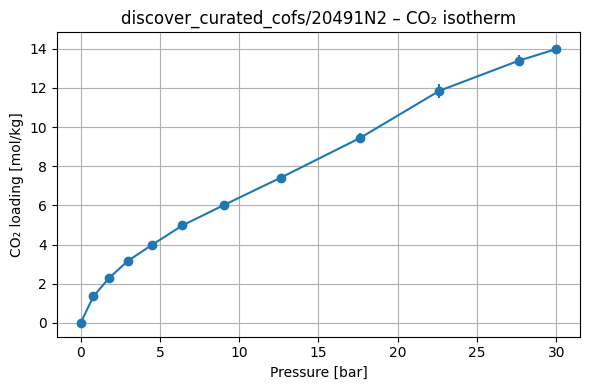

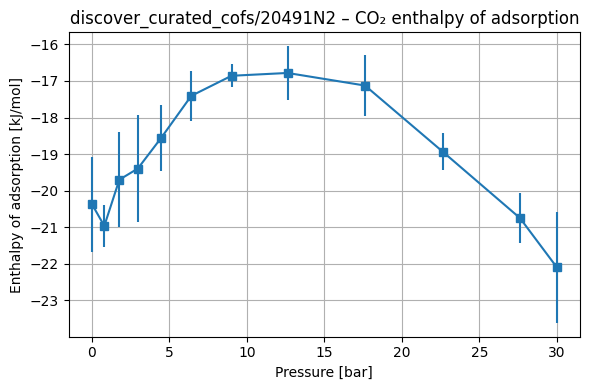

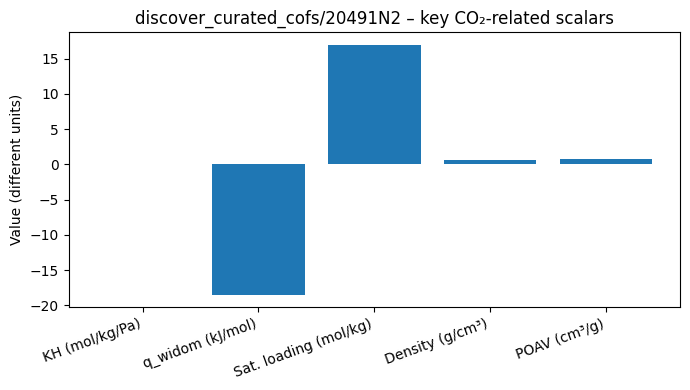

✅ Visualization complete for discover_curated_cofs/20491N2


In [35]:
visualize_cof(example_group)

In [36]:
# Pull out the isotherm dictionary and the arrays we care about.

attrs = co2_iso.base.attributes.all
iso = attrs['isotherm']

pressure = iso['pressure']                          # list of pressures
loading = iso['loading_absolute_average']           # average loading at each P
pressure_unit = iso['pressure_unit']
loading_unit = iso['loading_absolute_unit']

print("First few pressure points:", pressure[:5])
print("First few loadings:", loading[:5])

# Plot pressure vs loading
plt.figure()
plt.plot(pressure, loading, marker='o')
plt.xlabel(f"Pressure [{pressure_unit}]")
plt.ylabel(f"Loading [{loading_unit}]")
plt.title(f"{example_group.label} CO₂ isotherm at {attrs['temperature']} {attrs['temperature_unit']}")
plt.grid(True)
plt.show()


NameError: name 'co2_iso' is not defined

In [ ]:
# Create a DataFrame for this single isotherm

df_iso = pd.DataFrame({
    f'pressure_{pressure_unit}': pressure,
    f'loading_{loading_unit}': loading,
    'loading_dev_' + loading_unit: iso['loading_absolute_dev'],
    'qst_' + iso['enthalpy_of_adsorption_unit']: iso['enthalpy_of_adsorption_average'],
    'qst_dev_' + iso['enthalpy_of_adsorption_unit']: iso['enthalpy_of_adsorption_dev'],
})

df_iso.head()


,pressure_bar,loading_mol/kg,loading_dev_mol/kg,qst_kJ/mol,qst_dev_kJ/mol
0,0.001,0.000595,0.000394,-14.672417,2.224016
1,5.001,2.795528,0.063661,-14.044166,0.989585
2,10.001,5.296647,0.175676,-14.351283,1.494466
3,15.001,8.014907,0.188157,-14.875224,1.099452
4,20.001,10.686700,0.429697,-15.208467,0.436358


In [ ]:
df_iso.to_csv('example_cof_co2_isotherm.csv', index=False)
print("💾 Saved example COF CO₂ isotherm to 'example_cof_co2_isotherm.csv'")

💾 Saved example COF CO₂ isotherm to 'example_cof_co2_isotherm.csv'


In [ ]:
rows = []

for g in cof_groups:
    label = g.label                     # e.g. 'discover_curated_cofs/05001N2'
    cof_id = label.split('/')[-1]       # e.g. '05001N2'

    co2_nodes = [
        n for n in g.nodes
        if n.base.extras.get('tag4') == 'isot_co2'
    ]
    if not co2_nodes:
        # This COF might not have CO2 data – skip it
        continue

    co2 = co2_nodes[0]
    attrs = co2.base.attributes.all
    iso = attrs.get('isotherm')

    row = {
        'cof_id': cof_id,
        'group_label': label,

        # Scalar properties from attributes
        'density_g_cm3': attrs.get('Density'),
        'temperature_K': attrs.get('temperature'),
        'POAV_cm3_g': attrs.get('POAV_cm^3/g'),
        'PONAV_cm3_g': attrs.get('PONAV_cm^3/g'),
        'POAV_vol_frac': attrs.get('POAV_Volume_fraction'),
        'PONAV_vol_frac': attrs.get('PONAV_Volume_fraction'),
        'is_porous': attrs.get('is_porous'),
        'is_kh_enough': attrs.get('is_kh_enough'),
        'henry_coeff_mol_kg_Pa': attrs.get('henry_coefficient_average'),
        'henry_coeff_dev': attrs.get('henry_coefficient_dev'),
        'adsorption_energy_widom_kJ_mol': attrs.get('adsorption_energy_widom_average'),
        'adsorption_energy_widom_dev': attrs.get('adsorption_energy_widom_dev'),
        'estimated_saturation_loading_mol_kg': attrs.get('Estimated_saturation_loading'),
        'conversion_molec_uc_to_mg_g': attrs.get('conversion_factor_molec_uc_to_mg_g'),
        'conversion_molec_uc_to_mol_kg': attrs.get('conversion_factor_molec_uc_to_mol_kg'),
        'conversion_molec_uc_to_cm3stp_cm3': attrs.get('conversion_factor_molec_uc_to_cm3stp_cm3'),
        # isotherm resolution
        'n_isotherm_points': len(iso['pressure']) if iso else None,
        "isotherm": iso,
    }

    rows.append(row)

len(rows)


798

In [ ]:
df_scalar = pd.DataFrame(rows)
print(df_scalar.head())



    cof_id                    group_label  density_g_cm3  temperature_K  \
0  2245fN2  discover_curated_cofs/2245fN2       0.701006          300.0   
1  22000N2  discover_curated_cofs/22000N2       0.502401          300.0   
2  20490N2  discover_curated_cofs/20490N2       0.565759          300.0   
3  21451N2  discover_curated_cofs/21451N2       0.341797          300.0   
4  20491N2  discover_curated_cofs/20491N2       0.633766          300.0   

   POAV_cm3_g  PONAV_cm3_g  POAV_vol_frac  PONAV_vol_frac  is_porous  \
0    0.673931          0.0        0.47243             0.0       True   
1    1.410630          0.0        0.70870             0.0       True   
2    0.931103          0.0        0.52678             0.0       True   
3    2.226850          0.0        0.76113             0.0       True   
4    0.800248          0.0        0.50717             0.0       True   

  is_kh_enough  henry_coeff_mol_kg_Pa  henry_coeff_dev  \
0         True               0.000015     3.544330e-08   


In [ ]:
print(df_scalar.describe(include='all'))

         cof_id                    group_label  density_g_cm3  temperature_K  \
count       798                            798     798.000000          775.0   
unique      798                            798            NaN            NaN   
top     2245fN2  discover_curated_cofs/2245fN2            NaN            NaN   
freq          1                              1            NaN            NaN   
mean        NaN                            NaN       0.613460          300.0   
std         NaN                            NaN       0.251559            0.0   
min         NaN                            NaN       0.051403          300.0   
25%         NaN                            NaN       0.453026          300.0   
50%         NaN                            NaN       0.572230          300.0   
75%         NaN                            NaN       0.739357          300.0   
max         NaN                            NaN       1.757060          300.0   

        POAV_cm3_g  PONAV_cm3_g  POAV_v

In [ ]:
df_scalar.to_csv('curated_cofs_co2_scalar_properties.csv', index=False)
print("💾 Saved scalar CO₂ properties for all COFs to 'curated_cofs_co2_scalar_properties.csv'")

💾 Saved scalar CO₂ properties for all COFs to 'curated_cofs_co2_scalar_properties.csv'


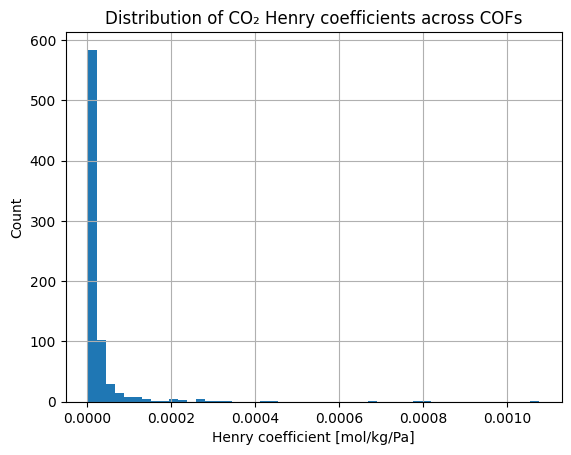

In [ ]:
plt.figure()
df_scalar['henry_coeff_mol_kg_Pa'].hist(bins=50)
plt.xlabel('Henry coefficient [mol/kg/Pa]')
plt.ylabel('Count')
plt.title('Distribution of CO₂ Henry coefficients across COFs')
plt.show()


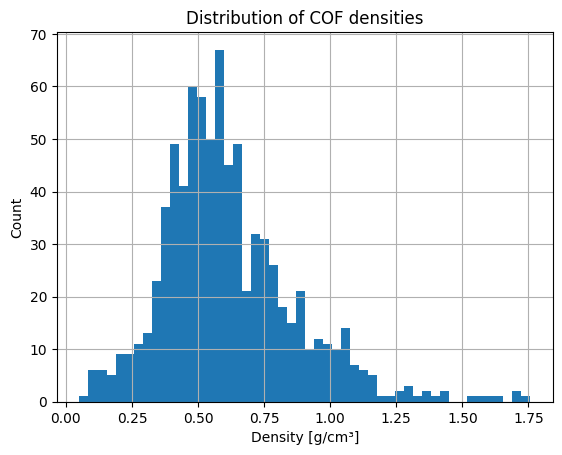

In [ ]:
plt.figure()
df_scalar['density_g_cm3'].hist(bins=50)
plt.xlabel('Density [g/cm³]')
plt.ylabel('Count')
plt.title('Distribution of COF densities')
plt.show()


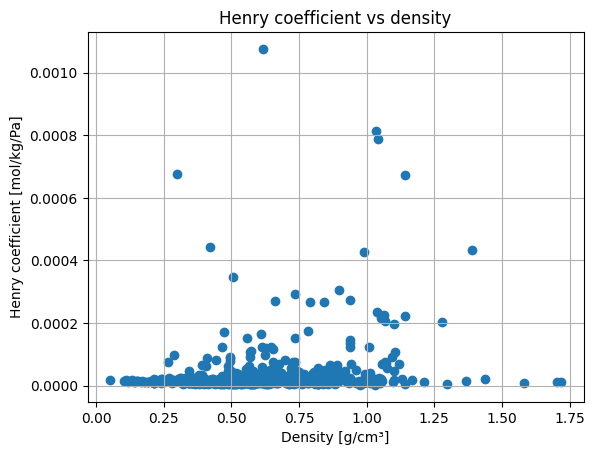

In [ ]:
plt.figure()
plt.scatter(df_scalar['density_g_cm3'], df_scalar['henry_coeff_mol_kg_Pa'])
plt.xlabel('Density [g/cm³]')
plt.ylabel('Henry coefficient [mol/kg/Pa]')
plt.title('Henry coefficient vs density')
plt.grid(True)
plt.show()


In [ ]:
def sample_loading(iso_dict, idx):
    """Safely get loading at index idx, or None if not available."""
    lst = iso_dict['loading_absolute_average']
    if idx < 0:
        idx = len(lst) + idx
    if idx < 0 or idx >= len(lst):
        return None
    return lst[idx]

rows = []

for g in cof_groups:
    label = g.label
    cof_id = label.split('/')[-1]

    co2_nodes = [
        n for n in g.nodes
        if n.base.extras.get('tag4') == 'isot_co2'
    ]
    if not co2_nodes:
        continue

    co2 = co2_nodes[0]
    attrs = co2.base.attributes.all
    iso = attrs.get('isotherm')

    pressures = iso['pressure'] if iso else None
    n_points = len(pressures) if iso else None

    low_idx = 0
    mid_idx = n_points // 2 if iso else None
    high_idx = -1

    row = {
        'cof_id': cof_id,
        'density_g_cm3': attrs.get('Density'),
        'henry_coeff_mol_kg_Pa': attrs.get('henry_coefficient_average'),
        'adsorption_energy_widom_kJ_mol': attrs.get('adsorption_energy_widom_average'),
        'n_isotherm_points': n_points if iso else None,
        'loading_lowP': sample_loading(iso, low_idx) if iso else None,
        'loading_midP': sample_loading(iso, mid_idx) if iso else None,
        'loading_highP': sample_loading(iso, high_idx) if iso else None,
    }
    rows.append(row)

df_sampled = pd.DataFrame(rows)
df_sampled.head()


,cof_id,density_g_cm3,henry_coeff_mol_kg_Pa,adsorption_energy_widom_kJ_mol,n_isotherm_points,loading_lowP,loading_midP,loading_highP
0,2245fN2,0.701006,0.000015,-14.763192,12.0,0.001548,12.766455,14.962725
1,22000N2,0.502401,0.000006,-11.630367,7.0,0.000595,8.014907,16.268264
2,20490N2,0.565759,0.000015,-19.096116,11.0,0.001397,6.479237,15.527194
3,21451N2,0.341797,0.000009,-11.513440,7.0,0.001194,13.999416,26.052974
4,20491N2,0.633766,0.000021,-18.482365,12.0,0.001843,6.007675,13.982232


In [ ]:
df_sampled.to_csv('curated_cofs_co2_sampled_isotherms.csv', index=False)
print("💾 Saved sampled-ISOTHERMS dataset to 'curated_cofs_co2_sampled_isotherms.csv'")


💾 Saved sampled-ISOTHERMS dataset to 'curated_cofs_co2_sampled_isotherms.csv'


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Drop rows with missing values in key columns
features = ['density_g_cm3', 'loading_lowP', 'loading_midP', 'loading_highP']
target = 'henry_coeff_mol_kg_Pa'

df_ml = df_sampled.dropna(subset=features + [target])
print("Rows available for ML:", len(df_ml))

X = df_ml[features].values
y = df_ml[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("R² score on test set:", r2)
print("Coefficients (per feature):")
for name, coef in zip(features, model.coef_):
    print(f"  {name}: {coef}")
print("Intercept:", model.intercept_)


Rows available for ML: 775
R² score on test set: 0.9978015412514654
Coefficients (per feature):
  density_g_cm3: -1.791947106506831e-07
  loading_lowP: 0.010164474924908944
  loading_midP: 7.827954820627788e-08
  loading_highP: -4.923355236403667e-08
Intercept: -2.576678638243444e-07
